In [9]:
import os
import re
import cv2
import json
import random
import numpy as np
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
from collections import Counter
from collections import defaultdict

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.models.efficientnet import EfficientNet_B0_Weights
from torchvision.models import efficientnet_b0
from torch.optim.lr_scheduler import ReduceLROnPlateau
from nltk.translate.bleu_score import sentence_bleu

In [10]:
# //TODO::WTF::

IMAGES_DIR = "/kaggle/input/flickr8k/Images"
CAPTIONS_FILE = "/kaggle/input/flickr8k/captions.txt"

BATCH_SIZE = 64

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [11]:
def load_captions(captions_file):
    captions_dict = {}
    with open(captions_file, 'r') as file:
        for line in file:
            tokens = line.strip().split(",") 
            if len(tokens) == 2:
                image_id, caption = tokens
                if image_id not in captions_dict:
                    captions_dict[image_id] = []
                captions_dict[image_id].append(caption)
    return captions_dict

def display_images_with_captions(images_dir, captions_dict, num_images=3, image_size=(224, 224)):
    images = list(captions_dict.keys())

    if len(images) < num_images:
        raise ValueError(f"Requested {num_images} images, but only {len(images)} available.")
    
    selected_images = random.sample(images, num_images)
    plt.figure(figsize=(10 * num_images, 10))
    
    for i, image in enumerate(selected_images):
        img_path = os.path.join(images_dir, image)
        img = Image.open(img_path)
        
        plt.subplot(num_images, 1, i + 1)
        plt.imshow(img)
        plt.axis('off')
        
        captions = "\n".join(captions_dict[image]) 
        plt.title(captions, fontsize=10, loc='center', wrap=True)
    
    plt.tight_layout()
    plt.show()

def plot_training_losses(train_losses, val_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(train_losses) + 1), train_losses, marker='o', label='Training Loss')
    plt.plot(range(1, len(val_losses) + 1), val_losses, marker='x', label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.grid(True)
    plt.legend()
    plt.show()

def visualize_results(model, dataloader, tokenizer, num_images=5):
    for images, _ in dataloader:
        images = images[:num_images].to(device)
        captions = [generate_caption(model, image, tokenizer) for image in images]

        plt.figure(figsize=(5, num_images * 5))

        for i in range(num_images):
            ax = plt.subplot(num_images, 1, i + 1)
            ax.imshow(images[i].permute(1, 2, 0).cpu().numpy())
            ax.axis("off")  # Remove axes
            ax.set_title(captions[i], fontsize=12, wrap=True)

        plt.tight_layout()
        plt.show()
        break

# def display_random_images_with_captions(images_dir, captions_dict, num_images=5):
#     selected_images = random.sample(list(captions_dict.keys()), num_images)
#     plt.figure(figsize=(15, 10))

#     for i, image_id in enumerate(selected_images):
#         img_path = f"{images_dir}/{image_id}"
#         img = Image.open(img_path)

#         plt.subplot(num_images, 1, i + 1)
#         # plt.subplot(1, num_images, i + 1)
#         plt.imshow(img)
#         plt.axis("off")
#         plt.title(captions_dict[image_id], fontsize=10)
    
#     plt.tight_layout()
#     plt.show()
        
def plot_caption_length_variation(captions_dict):
    lengths = []
    for captions in captions_dict.values():
        lengths.extend([len(caption.split()) for caption in captions])
    
    plt.figure(figsize=(15, 10))
    plt.scatter(range(len(lengths)), lengths, alpha=0.5)
    plt.title("Variation in Caption Lengths", fontsize=14)
    plt.xlabel("Caption Index", fontsize=12)
    plt.ylabel("Caption Length (Number of Words)", fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.show()

def plot_word_frequency_histogram(captions_dict, top_n=20):
    word_counter = Counter()
    for captions in captions_dict.values():
        for caption in captions:
            preprocessed_caption = preprocess_text(caption)
            word_counter.update(preprocessed_caption.split())
    
    most_common_words = word_counter.most_common(top_n)
    words, counts = zip(*most_common_words)

    plt.figure(figsize=(12, 6))
    plt.bar(words, counts, color='skyblue')
    plt.title(f"Top {top_n} Most Frequent Words", fontsize=14)
    plt.xlabel("Words", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.xticks(rotation=45, fontsize=10)
    plt.tight_layout()
    plt.show()

In [12]:
def split_dataset(captions_dict, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1, random_seed=42):
    assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-6, "Ratios must sum to 1."

    flattened_captions = []
    for image_id, captions in captions_dict.items():
        for caption in captions:
            flattened_captions.append((image_id, caption))

    random.seed(random_seed)
    random.shuffle(flattened_captions)

    total_samples = len(flattened_captions)
    train_end = int(total_samples * train_ratio)
    val_end = train_end + int(total_samples * val_ratio)

    train_samples = flattened_captions[:train_end]
    val_samples = flattened_captions[train_end:val_end]
    test_samples = flattened_captions[val_end:]

    train_captions = {image_id: [] for image_id, _ in train_samples}
    for image_id, caption in train_samples:
        train_captions[image_id].append(caption)

    val_captions = {image_id: [] for image_id, _ in val_samples}
    for image_id, caption in val_samples:
        val_captions[image_id].append(caption)

    test_captions = {image_id: [] for image_id, _ in test_samples}
    for image_id, caption in test_samples:
        test_captions[image_id].append(caption)

    return train_captions, val_captions, test_captions

def save_captions_to_json(captions, filepath):
    with open(filepath, 'w') as file:
        json.dump(captions, file, ensure_ascii=False, indent=4)

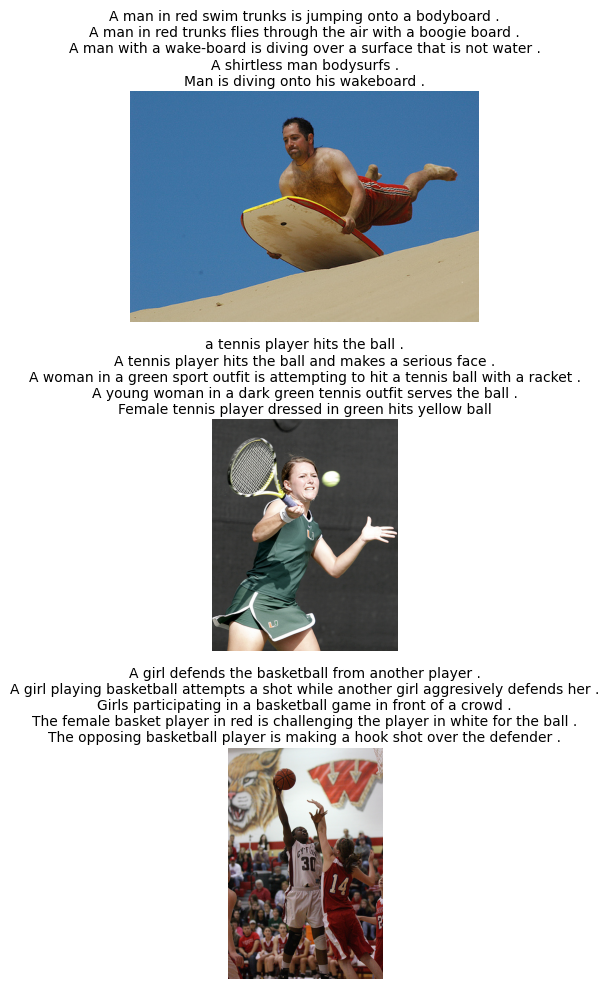

In [13]:
captions_dict = load_captions(CAPTIONS_FILE)
display_images_with_captions(IMAGES_DIR, captions_dict)

In [14]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"[^\w\s]", "", text)  # Remove punctuation
    text = re.sub(r"\d+", "", text)      # Remove numbers
    return text.strip()

def build_tokenizer(captions_dict):
    special_tokens = {"<pad>": 0, "<sos>": 1, "<eos>": 2, "<unk>": 3}
    word_to_index = defaultdict(lambda: special_tokens["<unk>"], special_tokens.copy())
    
    # Tokenize captions and build vocabulary
    vocab = set()
    for captions in captions_dict.values():
        for caption in captions:
            preprocessed_caption = preprocess_text(caption)
            vocab.update(preprocessed_caption.split())
    
    # Add vocabulary words to the tokenizer
    for idx, word in enumerate(sorted(vocab), start=len(special_tokens)):
        word_to_index[word] = idx
    
    return dict(word_to_index)

def caption_tokenizer_with_mask(caption, word_to_index, max_length=50):
    tokens = ["<sos>"] + caption.lower().split() + ["<eos>"]
    token_ids = [word_to_index.get(word, word_to_index["<unk>"]) for word in tokens]
    token_ids = token_ids[:max_length]
    masks = [True] * len(token_ids) + [False] * (max_length - len(token_ids))
    token_ids += [word_to_index["<pad>"]] * (max_length - len(token_ids))
    return torch.tensor(token_ids), torch.tensor(masks)

def save_tokenizer_to_json(tokenizer, filepath):
    with open(filepath, 'w') as file:
        json.dump(tokenizer, file, ensure_ascii=False, indent=4)

In [15]:
word_to_index_tokenizer = build_tokenizer(captions_dict)

TOKENIZER_FILE = "tokenizer.json"
save_tokenizer_to_json(word_to_index_tokenizer, TOKENIZER_FILE)

print(f"Word to Index Tokenizer saved to {TOKENIZER_FILE}. Total tokens: {len(word_to_index_tokenizer)}")

Word to Index Tokenizer saved to tokenizer.json. Total tokens: 8478


In [16]:
train_captions, val_captions, test_captions = split_dataset(captions_dict)

save_captions_to_json(train_captions, "train_captions.json")
save_captions_to_json(val_captions, "val_captions.json")
save_captions_to_json(test_captions, "test_captions.json")

print("Dataset split complete:")
print(f"Training: {len(train_captions)} images")
print(f"Validation: {len(val_captions)} images")
print(f"Test: {len(test_captions)} images")

Dataset split complete:
Training: 8084 images
Validation: 3166 images
Test: 3119 images


In [17]:
class FlickrDataset(Dataset):
    def __init__(self, captions_file, images_dir, transform=None, tokenizer=None, max_seq_length=50):
        with open(captions_file, 'r') as file:
            self.captions_dict = json.load(file)

        self.images_dir = images_dir
        self.transform = transform
        self.tokenizer = tokenizer
        self.max_seq_length = max_seq_length

        self.image_caption_pairs = []
        for image_id, captions in self.captions_dict.items():
            image_path = os.path.join(images_dir, image_id)
            if os.path.exists(image_path):
                for caption in captions:
                    self.image_caption_pairs.append((image_id, caption))
        
        random.shuffle(self.image_caption_pairs)
    
    def __len__(self):
        return len(self.image_caption_pairs)

    def __getitem__(self, idx):
        image_id, caption = self.image_caption_pairs[idx]
        image_path = os.path.join(self.images_dir, image_id)

        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        
        if self.tokenizer:
            caption = self.tokenizer(caption)

        return image, torch.tensor(caption) # caption

def create_dataloaders(images_dir, train_captions_file, val_captions_file, test_captions_file, batch_size, tokenizer):
    transform_train = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(p=0.25),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.RandomRotation(degrees=15),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    val_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])

    train_dataset = FlickrDataset(train_captions_file, images_dir, transform=transform_train, tokenizer=tokenizer)
    val_dataset = FlickrDataset(val_captions_file, images_dir, transform=val_transform, tokenizer=tokenizer)
    test_dataset = FlickrDataset(test_captions_file, images_dir, transform=val_transform, tokenizer=tokenizer)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

    return train_loader, val_loader, test_loader

In [18]:
class EncoderCNN(nn.Module):
    def __init__(self, output_size):
        super(EncoderCNN, self).__init__()
        self.efficient_net = efficientnet_b0(pretrained=True)
        for param in self.efficient_net.parameters():
            param.requires_grad = False
        self.efficient_net.classifier = nn.Linear(self.efficient_net.classifier[1].in_features, output_size)

    def forward(self, images):
        return self.efficient_net(images)

class DecoderTransformer(nn.Module):
    def __init__(self, vocab_size, embed_size, num_heads, hidden_dim, num_layers, max_seq_length, pad_idx):
        super(DecoderTransformer, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size, padding_idx=pad_idx)
        self.positional_encoding = nn.Parameter(torch.zeros(1, max_seq_length, embed_size))
        self.transformer = nn.Transformer(
            d_model=embed_size, nhead=num_heads, num_encoder_layers=num_layers, num_decoder_layers=num_layers
        )
        self.fc = nn.Linear(embed_size, vocab_size)

    def forward(self, image_features, captions):
        captions = self.embedding(captions) + self.positional_encoding[:, :captions.size(1), :]
        transformer_out = self.transformer(image_features.unsqueeze(0), captions.permute(1, 0, 2))
        return self.fc(transformer_out)

class ImageCaptioningModel(nn.Module):
    def __init__(self, vocab_size, embed_size, num_heads, hidden_dim, num_layers, max_seq_length, pad_idx, encoder_output_size):
        super(ImageCaptioningModel, self).__init__()
        self.encoder = EncoderCNN(output_size=encoder_output_size)
        self.decoder = DecoderTransformer(
            vocab_size=vocab_size, 
            embed_size=embed_size, 
            num_heads=num_heads, 
            hidden_dim=hidden_dim, 
            num_layers=num_layers, 
            max_seq_length=max_seq_length, 
            pad_idx=pad_idx
        )

    def forward(self, images, captions):
        image_features = self.encoder(images)
        return self.decoder(image_features, captions)

In [19]:
def generate_caption(model, image, tokenizer, max_length=50):
    model.eval()
    with torch.no_grad():
        image_features = model.encoder(image.unsqueeze(0).to(device))
        caption = ["<sos>"]
        for _ in range(max_length):
            input_seq = torch.tensor([tokenizer[word] for word in caption], device=device).unsqueeze(0)
            outputs = model.decoder(image_features, input_seq)
            predicted_word_idx = outputs.argmax(dim=-1)[:, -1].item()
            predicted_word = {v: k for k, v in tokenizer.items()}[predicted_word_idx]
            if predicted_word == "<eos>":
                break
            caption.append(predicted_word)
        return " ".join(caption[1:])

def evaluate_bleu(model, dataloader):
    bleu_scores = []
    for images, captions in dataloader:
        for img, true_caption in zip(images, captions):
            generated_caption = generate_caption(model, img)
            score = sentence_bleu([true_caption.split()], generated_caption.split())
            bleu_scores.append(score)
    return sum(bleu_scores) / len(bleu_scores)

# def masked_cross_entropy_loss(outputs, targets, pad_idx):
#     loss_fn = nn.CrossEntropyLoss(ignore_index=pad_idx)
#     outputs = outputs.view(-1, outputs.size(-1))
#     targets = targets.view(-1)
#     return loss_fn(outputs, targets)

def masked_cross_entropy_loss(outputs, targets, pad_idx):
    loss_fn = nn.CrossEntropyLoss(ignore_index=pad_idx)
    return loss_fn(outputs.permute(0, 2, 1), targets)  # Permute for [batch_size, vocab_size, seq_len]

In [20]:
def train_model(
    model, train_loader, val_loader, optimizer, pad_idx, num_epochs=50, 
    checkpoint_path="checkpoint.pth", resume=False, patience=5,
    weight_decay=1e-4
):
    model.train()
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=patience-2)

    if resume and os.path.exists(checkpoint_path):
        start_epoch, _ = load_checkpoint(checkpoint_path, model, optimizer)
    else:
        start_epoch = 0
            
    best_val_loss = float('inf')
    train_losses, val_losses = [], []
    patience_counter = 0 
    
    for epoch in range(start_epoch, num_epochs):
        model.train()
        epoch_loss = 0
        tepoch = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)
        for batch_idx, (images, captions) in enumerate(tepoch):
            print(f"captions={captions}")
            images, captions = images.to(device), captions.to(device)
            
            optimizer.zero_grad()
            outputs = model(images, captions[:, :-1])  # Exclude the last word for teacher forcing            
            outputs = outputs[:, :captions.size(1) - 1, :]  # Match target sequence length
            # outputs = model(images, captions[:, :-1])  # Exclude <eos> for input captions

            loss = masked_cross_entropy_loss(outputs, captions[:, 1:], pad_idx)  # Exclude <sos> for target captions
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            tepoch.set_postfix(loss=f"{loss.item():.4f}")
        
        train_losses.append(epoch_loss / len(train_loader))
        print(f"Epoch {epoch+1}, Train Loss: {train_losses[-1]:.4f}")

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for images, captions in val_loader:
                images, captions = images.to(device), captions.to(device)
                # outputs = model(images, captions[:, :-1])
                outputs = model(images, captions[:, :-1])
                outputs = outputs[:, :captions.size(1) - 1, :]
                loss = masked_cross_entropy_loss(outputs, captions[:, 1:], pad_idx)
                val_loss += loss.item()
        
        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        print(f"Epoch {epoch+1}, Validation Loss: {val_loss:.4f}")

        scheduler.step(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0 
            save_checkpoint(model, optimizer, epoch + 1, val_loss, checkpoint_path)
            # torch.save(model.state_dict(), checkpoint_path)
            # print("Model checkpoint saved!")
        else:
            patience_counter += 1
            print(f"No improvement in validation loss for {patience_counter} epoch(s).")
            
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

    return train_losses, val_losses

In [21]:
with open(TOKENIZER_FILE, "r") as file:
    word_to_index = json.load(file)

train_loader, val_loader, test_loader = create_dataloaders(
    IMAGES_DIR,
    "train_captions.json",
    "val_captions.json",
    "test_captions.json",
    BATCH_SIZE,
    lambda caption: caption_tokenizer_with_mask(caption, word_to_index)
)

print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Testing batches: {len(test_loader)}")

Training batches: 476
Validation batches: 60
Testing batches: 60


In [22]:
vocab_size = len(word_to_index)
embed_size = 512
num_heads = 8
hidden_dim = 512
num_layers = 4
max_seq_length = 50
pad_idx = word_to_index["<pad>"]
encoder_output_size = 512

model = ImageCaptioningModel(
    vocab_size, embed_size, num_heads, hidden_dim, num_layers, max_seq_length, pad_idx, encoder_output_size
).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-4)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not

In [23]:
train_losses, val_losses = train_model(
    model, train_loader, val_loader, optimizer, pad_idx, num_epochs=100, checkpoint_path="caption_model.pth"
)

TypeError: Caught TypeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/worker.py", line 309, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/fetch.py", line 52, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/fetch.py", line 52, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "<ipython-input-17-0e5d9d0c9d67>", line 34, in __getitem__
    return image, torch.tensor(caption) # caption
TypeError: only integer tensors of a single element can be converted to an index


In [ ]:
bleu_score = evaluate_bleu(model, test_loader, word_to_index)
print(f"BLEU Score: {bleu_score:.4f}")